> # Homework 4 
> This homework contains several coding tasks and Q&A questions. For coding part, please write codes in corresponding cells. For Q&A, you will see cells with **Answer: HERE**. Please double click those cells and directly write your answer.

> You should use Python 3 to do this homework. Python 2 may not be supported. You can use either your own PC or Google Colab to do this homework.



> ## Due Date: Nov. 19, 23:00 SG Time
> ## Deliverables
> Save your notebook `ipynb` file as `StudentID_YourName_HW4.ipynb`, generate an `html` file from `ipynb` file and save as `StudentID_YourName_HW4.html`. Zip your notebook file and html file into a single `zip` file. 
>
> **Upload the `zip` file as `StudentID_YourName_HW4.zip`.**
>
> **Please make sure your code is executable.**
>
> ## HW4 has 80 points in total, which worths 8 points in the final assessment.

In [1]:
# Input your name and studentID
name = "Ong Jun Hong"
stuID = "A0202490R"

In [2]:
# Import packages
import numpy as np
import pandas as pd

import statsmodels.api as sm # recommended version: 0.13.0
from statsmodels.miscmodels.ordinal_model import OrderedModel

import xgboost as xgb # recommended version: 1.5.0
from xgboost import plot_importance

# sklearn package is only used for RMSE evaluation, you can write your own function if you like.
from sklearn import metrics 

In [3]:
# To fix random seeds (Note that you may still get slightly different results.)
np.random.seed(31415)

# To ignore some warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [4]:
# If you are using Google Colab and get an error regarding statsmodels(OrderedModel),
# you can use the following line to install statsmodels package
# This will takes a few minutes, please RESTART the RUNTIME after installation.

# !pip install git+https://github.com/statsmodels/statsmodels

# Background Information: About the Data (5 points)
The data set is obtained based on the following procedure: we have a set of keywords. For each keyword, we type it in Google, then we get the first 98 websites. It has $20\times98=1960$ observations in total. We have already split the dataset into training and test (or validation) dataset. The training dataset includes $70\%$ of observations ($14\times 98=1372$ rows) while the test dataset includes $30\%$ of observations ($6\times 98=588$ rows). 

There are two data files: Train_2021.csv for training data and Test_2021.csv for testing data. Please do not use Excel to open the data file as it may cause some unexpected errors. If you happen to open the data file by Excel, just download another one from the Homework Folder in LumiNUS.

## Load Data

In [5]:
# Load the training and test datasets and print the first 5 rows of the training dataset.
# Please use pd.read_csv("data.csv") to load your data
train_data = pd.read_csv('Train_2021.csv')

test_data = pd.read_csv('Test_2021.csv')

train_data.head()

,ID,Position,ReverseRank,Title,URL,Meta,TitleFlag,TitleDensity,URLFlag,URLDensity,MetaFlag,MetaDensity,PageAuthority,DomainAuthority,LinkingDomain,InboundLink,RankingKeyword
0,1,1,100,Job Interview Questions Singapore: Answers to ...,https://blog.carousell.com/job-interview-quest...,sep 19 2017 common job interview questions in ...,0,0.3000,0,0.4286,0,0.1017,32,60,4,5.0,4
1,2,2,99,Job Interview Questions - Hudson Singapore,https://www.hudson.sg/career-advice/job-interv...,discover the five most common job interview qu...,0,0.6000,0,0.2500,0,0.2174,19,30,0,0.0,9
2,3,3,98,20 tips that will help you ace your next job i...,http://www.asiaone.com/business/20-tips-will-h...,oct 8 2017 with singapore's unemployment rate ...,0,0.2143,0,0.2143,0,0.0645,40,80,3,400.0,0
3,4,4,97,Common interview questions and answers | Rober...,https://www.roberthalf.com.sg/career-advice/in...,knowing what job interview questions you might...,0,0.1429,0,0.1111,0,0.2500,22,40,0,0.0,4
4,5,5,96,10 Common Interview Questions and How to ... -...,http://gradsingapore.com/graduate-careers-advi...,don't be caught off guard in an interview try ...,0,0.2000,0,0.0714,0,0.1429,24,33,2,2.0,6


There are many columns in the data, e.g., title, url and meta desciptions. The detailed information about each column is in the appendix. We will only use: “TitleFlag”, “TitleDensity”, “URLFlag”, “URLDensity”, “MetaFlag”, “MetaDensity”, “PageAuthority”, “DomainAuthority”, “LinkingDomain”, “InboundLink” and “RankingKeyword” as features, **"ReverseRank" as label**.

In [6]:
# Split feature and label
train_feature = train_data.loc[:, ['TitleFlag', 'TitleDensity', 'URLFlag', 'URLDensity', 'MetaFlag', 'MetaDensity', 'PageAuthority', 'DomainAuthority', 'LinkingDomain', 'InboundLink', 'RankingKeyword']]
train_label = train_data.loc[:, 'ReverseRank']

test_feature = test_data.loc[:, ['TitleFlag', 'TitleDensity', 'URLFlag', 'URLDensity', 'MetaFlag', 'MetaDensity', 'PageAuthority', 'DomainAuthority', 'LinkingDomain', 'InboundLink', 'RankingKeyword']]
test_label = test_data.loc[:, 'ReverseRank']

In [7]:
# Run this cell
print(train_feature.shape,
      train_label.shape,
      test_feature.shape,
      test_label.shape)

(1372, 11) (1372,) (588, 11) (588,)


In [8]:
# Run this cell
train_data.head(5)

,ID,Position,ReverseRank,Title,URL,Meta,TitleFlag,TitleDensity,URLFlag,URLDensity,MetaFlag,MetaDensity,PageAuthority,DomainAuthority,LinkingDomain,InboundLink,RankingKeyword
0,1,1,100,Job Interview Questions Singapore: Answers to ...,https://blog.carousell.com/job-interview-quest...,sep 19 2017 common job interview questions in ...,0,0.3000,0,0.4286,0,0.1017,32,60,4,5.0,4
1,2,2,99,Job Interview Questions - Hudson Singapore,https://www.hudson.sg/career-advice/job-interv...,discover the five most common job interview qu...,0,0.6000,0,0.2500,0,0.2174,19,30,0,0.0,9
2,3,3,98,20 tips that will help you ace your next job i...,http://www.asiaone.com/business/20-tips-will-h...,oct 8 2017 with singapore's unemployment rate ...,0,0.2143,0,0.2143,0,0.0645,40,80,3,400.0,0
3,4,4,97,Common interview questions and answers | Rober...,https://www.roberthalf.com.sg/career-advice/in...,knowing what job interview questions you might...,0,0.1429,0,0.1111,0,0.2500,22,40,0,0.0,4
4,5,5,96,10 Common Interview Questions and How to ... -...,http://gradsingapore.com/graduate-careers-advi...,don't be caught off guard in an interview try ...,0,0.2000,0,0.0714,0,0.1429,24,33,2,2.0,6


In [9]:
# Run this cell
# This serves as your data input
# Please pay attention to your data type!

X_train = train_feature # trainig feature, as a pandas dataframe
X_test = test_feature # test feature, as a pandas dataframe

y_train = train_label.values # training label, as a numpy array
y_test = test_label.values # test label, as a numpy array

**Please be aware of the problem of shallow copy and deep copy. To avoid any issues, you are recommended to load data separately for each problem, although they may be the same.**

# Problem 1. (Pointwise Rank -- Linear Regression) (10 points)
Please use the training dataset to fit a linear regression with all variables aforementioned. **Use the `ReverseRank` as the target variable**. Please use the trained linear regression model to predict the rank in the test dataset and report the root mean square error (RMSE) of the prediction (i.e., $\sqrt{\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)^2}$, where $n$ is the total number of data points in the test dataset, $y_i$ is the true value of the target variable in the test dataset, and $\hat{y}_i$ is your model prediction).  (5 points)

Reference: https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

In [10]:
# Data Input if any
X_train = train_feature.copy() # trainig feature, as a pandas dataframe
X_test = test_feature.copy() # test feature, as a pandas dataframe

y_train = train_label.copy().values # training label, as a numpy array
y_test = test_label.copy().values # test label, as a numpy array

In [11]:
# Model: USE sm.OLS(y_train,X_train)
# Fit: USE model.fit()
# y_train is a numpy array from train_label, X_train is a pandas dataframe from train_feature.
# Remember to add an intercept by sm.add_constant() to both train and test data!

X_train = sm.add_constant(X_train)
model_ols = sm.OLS(y_train, X_train)
result = model_ols.fit()

In [12]:
# Print model summary by model.summary()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     14.39
Date:                Sat, 20 Nov 2021   Prob (F-statistic):           1.33e-26
Time:                        20:53:13   Log-Likelihood:                -6457.1
No. Observations:                1372   AIC:                         1.294e+04
Df Residuals:                    1360   BIC:                         1.300e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              32.4841      3.072     

In [13]:
# Make prediction 
X_test = sm.add_constant(X_test)
y_pred = result.predict(X_test)

In [14]:
# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction
print(metrics.mean_squared_error(y_test, y_pred, squared=False))

37.15072457246814


Pick the most statistically significant variable and interpret its estimated beta coefficient. (5 points)

Answer: The most statistically significant variable is: <code>URLDensity</code>. A beta coefficient of 34.8241 would mean that a 1 point increase in URLDensity (i.e. from 0.1 to 1.1) would improve my page's position in the query result by 34.8241 places.

However as you cannot achieve a 110% URL density normally, a more practical explanation would be increasing the URLDensity score by 0.1 (i.e 0.1 to 0.2) would lead to an improvement of 3.48241 places in the query result.

# Problem 2. (Pointwise Rank -- Logistic Regression) (15 points)

For logistic regression in general, it does not require to have an ordinal relationship among the different class labels of the target variable, e.g., class 1 does not have to imply superiority or inferiority when being compared with class 2. However, in some settings, one type of label does imply a higher value than other types of labels (e.g., in the final grade, $A$ is better than $B$). We will use **ordinal** logistic regression for this problem. (5 points)

Please use the training dataset to fit an **ordinal** logistic regression model with all variables aforementioned. **Use the `ReverseRank` as the target variable**.

Note that you may not be able to run ordinal logistic regression because the distributions of several variables are too skewed. You can use `new_variable = np.log(the_problematic_variable+1)` to **transform those variables in both training and testing data.** (5 points)

Please use the trained ordinal logistic regression model to predict the rank in the test dataset. Print the predicted rank on the test dataset and report the RMSE of the prediction. 

Reference: https://www.statsmodels.org/dev/examples/notebooks/generated/ordinal_regression.html

In [15]:
# Data Input if any
X_train = train_feature.copy() # trainig feature, as a pandas dataframe
X_test = test_feature.copy() # test feature, as a pandas dataframe

y_train = train_label.copy().values # training label, as a numpy array
y_test = test_label.copy().values # test label, as a numpy array

In [16]:
X_train.describe()

,TitleFlag,TitleDensity,URLFlag,URLDensity,MetaFlag,MetaDensity,PageAuthority,DomainAuthority,LinkingDomain,InboundLink,RankingKeyword
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.052478,0.214573,0.045918,0.129700,0.172741,0.139981,33.062682,52.835277,213.226676,4746.748542,45.609329
std,0.223071,0.165934,0.209384,0.129054,0.378161,0.069039,11.515904,24.432446,1683.831729,46706.309575,260.055053
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,0.000000,0.100000,0.000000,0.000000,0.000000,0.095200,26.000000,34.000000,0.000000,0.000000,0.000000
50%,0.000000,0.200000,0.000000,0.111100,0.000000,0.130400,32.000000,51.000000,3.000000,5.000000,3.000000
75%,0.000000,0.333300,0.000000,0.202625,0.000000,0.173900,40.000000,71.000000,22.000000,69.250000,17.000000
max,1.000000,0.857100,1.000000,0.714300,1.000000,0.571400,78.000000,100.000000,40500.000000,1000000.000000,4600.000000


In [17]:
# Adjust your input
# Please specify which parts of data you do a log transformation on.
X_train.loc[:, 'LinkingDomain'] = np.log(X_train.loc[:, 'LinkingDomain'] + 1)
X_train.loc[:, 'InboundLink'] = np.log(X_train.loc[:, 'InboundLink'] + 1)
X_train.loc[:, 'RankingKeyword'] = np.log(X_train.loc[:, 'RankingKeyword'] + 1)

X_test.loc[:, 'LinkingDomain'] = np.log(X_test.loc[:, 'LinkingDomain'] + 1)
X_test.loc[:, 'InboundLink'] = np.log(X_test.loc[:, 'InboundLink'] + 1)
X_test.loc[:, 'RankingKeyword'] = np.log(X_test.loc[:, 'RankingKeyword'] + 1)

In [18]:
# Model: USE OrderedModel(y_train, X_train, distr='logit')
# Fit: USE model.fit(method='bfgs', disp=False)
# y_train is a numpy array from train_label, X_train is a pandas dataframe from train_feature.
model_logit = OrderedModel(y_train, X_train, distr='logit')
result = model_logit.fit(method='bfgs', disp=False)

In [19]:
# Print model summary by model.summary()
print(result.summary())

                             OrderedModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -6220.1
Model:                   OrderedModel   AIC:                         1.266e+04
Method:            Maximum Likelihood   BIC:                         1.322e+04
Date:                Sat, 20 Nov 2021                                         
Time:                        20:53:34                                         
No. Observations:                1372                                         
Df Residuals:                    1264                                         
Df Model:                         108                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
TitleFlag           0.8615      0.275      3.129      0.002       0.322       1.401
TitleDensity        1.0371      0.352

In [20]:
# Make prediction: assume the predicted output of this model is y_pred, 
# for this problem, you need to do y_pred.argmax(1)+3 to get the real output.
# Please refer to the reference above for how to make prediction properly.
predicted = result.model.predict(result.params, exog=X_test)
y_pred = predicted.argmax(1) + 3

C:\Users\JunHo\anaconda3\lib\site-packages\statsmodels\miscmodels\ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


In [21]:
# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction
print(metrics.mean_squared_error(y_test, y_pred, squared=False))

37.61908529232592


Pick the most statistically significant variable and interpret its estimated beta coefficient. (5 points)

Answer: The most statistically significant variable is: <code>URLDensity</code>. A beta coefficient of 2.2298 would mean that a 0.1 point increase in URLDensity (i.e. from 0.1 to 0.2) would improve the odds of my page ranking higher in the query result by $\exp{(0.22298)} = 1.2498$ or 24.98% increase in odds.

# Problem 3. (Pairwise Rank -- xgboost) (35 points)
Please use the training dataset to fit an XGboost model with all variables aforementioned. **Use the `ReverseRank` as the target variable**. 

Show the feature importance plot. Use "Gain" for `measure` in the importance plot. 

For the XGboost prediction, please interpret the importance value of the most important variable. Please use the trained XGboost model to predict the rank in the test dataset and report the RMSE of the prediction. 


Reference: https://xgboost.readthedocs.io/en/latest/python/index.html

In [22]:
# Data Input if any
X_train = train_feature.copy() # trainig feature, as a pandas dataframe
X_test = test_feature.copy() # test feature, as a pandas dataframe

y_train = train_label.copy().values # training label, as a numpy array
y_test = test_label.copy().values # test label, as a numpy array

## Question 1.Use `reg:linear` for `objective` and `rmse` for `eval_metric`. (10 points)
Try different combinations of the hyper-parameters to get a lower RMSE. (5 points)

In [23]:
# Model and Parameter Setting 
# Use xgb.XGBRegressor
# Use parameters below first and you can adjust it later.
your_model = xgb.XGBRegressor(max_depth = 6, 
                       eta = 0.1, 
                       gamma = 0.1,
                       subsample = 0.8,
                       colsample_bytree = 0.8,
                       alpha = 0.5,
                       objective = "reg:linear",
                       eval_metric = "rmse")

In [24]:
# Fit the model by your_model.fit(X_train, y_train)
result = your_model.fit(X_train, y_train)

[20:53:35] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

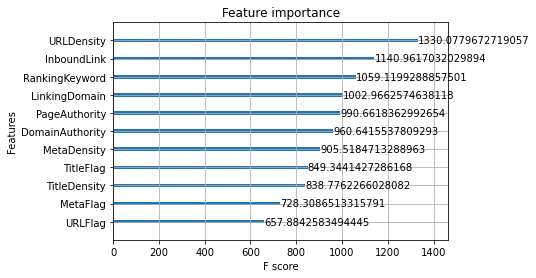

In [25]:
# Show the feature importance plot. Use plot_importance(your_model, importance_type = 'gain')
# If you don't see your plot, please run this cell again.
plot_importance(result, importance_type='gain')

Please interpret the importance value of the most important variable. (5 points)

According to the documentation provided above, <code>Gain</code> is the improvement in accuracy brought by a feature to the branches it is on. The idea is that before adding a new split on a feature X to the branch there was some wrongly classified elements, after adding the split on this feature, there are two new branches, and each of these branch is more accurate (one branch saying if your observation is on this branch then it should be classified as 1, and the other branch saying the exact opposite).

Answer: URLDensity with an importance value of 1330.08 is the most important factor when predicting the position of the webpage in the query results. As the feature importance is calculated relative to the other features, this means URL density  provides a $(1330.08 - 1140.96)/1140.96 = 16.58\%$ larger improvement in predicting power compared to inbound links.

In [26]:
# Make prediction: y_pred should be the output of your prediction, it cotains value
# from 3 to 100 (may not be integers)
y_pred = result.predict(X_test)

In [27]:
# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction
old_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
print(old_rmse)

27.171698109163444


Trying different combinations of the hyper-parameters to get a lower RMSE.

In [28]:
# Data Input if any
X_train = train_feature.copy() # trainig feature, as a pandas dataframe
X_test = test_feature.copy() # test feature, as a pandas dataframe

y_train = train_label.copy().values # training label, as a numpy array
y_test = test_label.copy().values # test label, as a numpy array

# Model and Parameter Setting 
# Use xgb.XGBRegressor
# Use parameters below first and you can adjust it later.
your_model = xgb.XGBRegressor(max_depth = 4,
                       eta = 0.1, 
                       gamma = 0.1,
                       subsample = 0.8,
                       colsample_bytree = 0.8,
                       alpha = 0.5,
                       objective = "reg:linear",
                       eval_metric = "rmse")

# Fit the model by your_model.fit(X_train, y_train)
result = your_model.fit(X_train, y_train)

# Make prediction: y_pred should be the output of your prediction, it cotains value
# from 3 to 100 (may not be integers)
y_pred = result.predict(X_test)

# Print RMSE, y_test is a numpy array from test_label, y_pred is a numpy array from your model prediction
new_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
print('Old RMSE: {}\nNew RMSE: {}'.format(old_rmse, new_rmse))

[20:53:36] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
Old RMSE: 27.171698109163444
New RMSE: 26.347989198299977


## Question 2. Redo Question 1 by using `rank:pairwise` for `objective` and `rmse` for `eval_metric`. (15 points)
Note that Question 1 did not utilize the query information. However, in the dataset, we know that each query corresponds to 98 data points. Now we will utilize this information by setting group information for both training and testing data. (5 points)

Try different combinations of the hyper-parameters to get a lower RMSE. (5 points)

In [29]:
# Data Input if any
X_train = train_feature.copy() # trainig feature, as a pandas dataframe
X_test = test_feature.copy() # test feature, as a pandas dataframe

y_train = train_label.copy().values # training label, as a numpy array
y_test = test_label.copy().values # test label, as a numpy array

In [30]:
# Model and Parameter Setting 
# Use xgb.XGBRanker
# Use parameters below first and you can adjust it later.
your_model = xgb.XGBRanker(max_depth = 6, 
                           eta = 0.1, 
                           gamma = 0.1,
                           subsample = 0.8,
                           colsample_bytree = 0.8,
                           alpha = 0.5,
                           objective = "rank:pairwise",
                           eval_metric = "rmse")


# Fit the model by your_model.fit(X_train, y_train, group = np.full(14,98))
result = your_model.fit(X_train, y_train, group = np.full(14,98))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

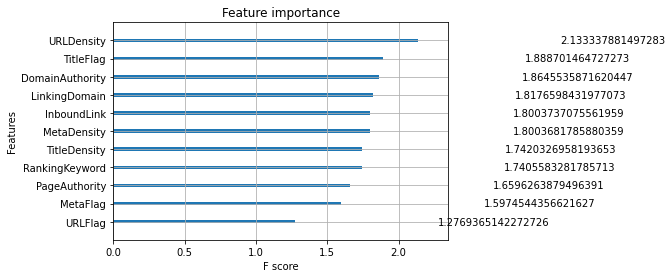

In [31]:
# Show the feature importance plot. Use plot_importance(your_model, importance_type = 'gain')
plot_importance(your_model, importance_type = 'gain')

Please interpret the importance value of the most important variable. (5 points)

Answer: URL density is the most important feature when predicting which page within a pair of pages would have a higher rank. It is $(2.13-1.89)/1.89 = 12.70\%$ more effective in predicting the order of a pair of pages compared to title flag.

Hint for next step:

Note that here y_pred is NOT a direct rank. You need to figure out how to get rank from y_pred. Test data can be divided into 6 groups, you need to perform the following operations for each group. For each group, get y_pred from your model. The values in y_pred indicate a relative score for rank. The higher the score, the better the page rank. For all 98 pages in one group, the page with the highest score should rank as 100, and the page with the lowest score should rank as 3. Repeat this for all groups. You are required to implement this by some simple codes. **y_pred_rank** is the actually predicted ranks you transformed from **y_pred**.

In [32]:
import scipy.stats as ss

In [33]:
# Make prediction: y_pred is the predicted output from your model, y_pred_rank is the actual rank you get
y_pred = result.predict(X_test)
pred = []

for i in range(0, len(y_pred), 98):
    rank = ss.rankdata(y_pred[i:i+98]) + 2
    pred.append(rank)
    
y_pred_rank = np.array(pred).flatten()

In [34]:
# Print RMSE, y_test is a numpy array from test_label, y_pred_rank is a numpy array from your model prediction
old_rmse = metrics.mean_squared_error(y_test, y_pred_rank, squared=False)
print(old_rmse)

31.815796359028695


Trying different combinations of the hyper-parameters to get a lower RMSE.

In [35]:
# Data Input if any
X_train = train_feature.copy() # trainig feature, as a pandas dataframe
X_test = test_feature.copy() # test feature, as a pandas dataframe

y_train = train_label.copy().values # training label, as a numpy array
y_test = test_label.copy().values # test label, as a numpy array

# Model and Parameter Setting 
# Use xgb.XGBRanker
# Use parameters below first and you can adjust it later.
your_model = xgb.XGBRanker(max_depth = 4, 
                           eta = 0.1, 
                           gamma = 0.1,
                           subsample = 0.8,
                           colsample_bytree = 0.8,
                           alpha = 0.5,
                           objective = "rank:pairwise",
                           eval_metric = "rmse")


# Fit the model by your_model.fit(X_train, y_train, group = np.full(14,98))
result = your_model.fit(X_train, y_train, group = np.full(14,98))

# Make prediction: y_pred is the predicted output from your model, y_pred_rank is the actual rank you get
y_pred = result.predict(X_test)
pred = []

for i in range(0, len(y_pred), 98):
    rank = ss.rankdata(y_pred[i:i+98]) + 2
    pred.append(rank)
    
y_pred_rank = np.array(pred).flatten()

# Print RMSE, y_test is a numpy array from test_label, y_pred_rank is a numpy array from your model prediction
new_rmse = metrics.mean_squared_error(y_test, y_pred_rank, squared=False)
print('Old RMSE: {}\nNew RMSE: {}'.format(old_rmse, new_rmse))

Old RMSE: 31.815796359028695
New RMSE: 30.69240638209734


## Question 3.Use `rank:ndcg` for `objective` and `rmse` for `eval_metric`. Redo Question 2. (10 points)

Try different combinations of the hyper-parameters to get a lower RMSE. (5 points)

In [36]:
# Data Input if any
X_train = train_feature.copy() # trainig feature, as a pandas dataframe
X_test = test_feature.copy() # test feature, as a pandas dataframe

y_train = train_label.copy().values # training label, as a numpy array
y_test = test_label.copy().values # test label, as a numpy array

In [37]:
# Model and Parameter Setting 
# Use xgb.XGBRanker
# Use parameters below first and you can adjust it later.
your_model = xgb.XGBRanker(max_depth = 6, 
                           eta = 0.1, 
                           gamma = 0.1,
                           subsample = 0.8,
                           colsample_bytree = 0.8,
                           alpha = 0.5,
                           objective = "rank:ndcg",
                           eval_metric = "rmse")


# Fit the model by your_model.fit(X_train, y_train, group = np.full(14,98))
result = your_model.fit(X_train, y_train, group = np.full(14,98))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

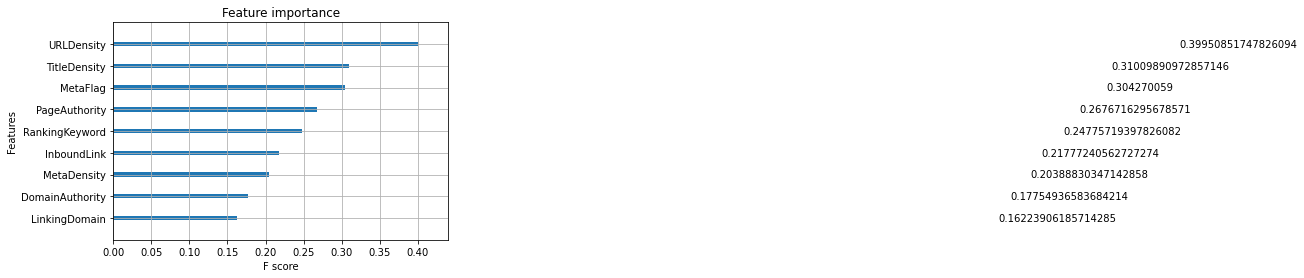

In [38]:
# Show the feature importance plot. Use plot_importance(your_model, importance_type = 'gain')
plot_importance(your_model, importance_type = 'gain')

Please interpret the importance value of the most important variable. (5 points)

Answer: Based on the position of the respective webpages in each query in the training set, the model identified that URL density is likely to be the most significant feature used in the search engine so as to achieve the observed results in the training set.

In [39]:
# Make prediction: y_pred is the predicted output from your model, y_pred_rank is the actual rank you get.
# Follow the Hint in P3-Q2
y_pred = result.predict(X_test)
pred = []

for i in range(0, len(y_pred), 98):
    rank = ss.rankdata(y_pred[i:i+98]) + 2
    pred.append(rank)
    
y_pred_rank = np.array(pred).flatten()

In [40]:
# Print RMSE, y_test is a numpy array from test_label, y_pred_rank is a numpy array from your model prediction
old_rmse = metrics.mean_squared_error(y_test, y_pred_rank, squared=False)
print(old_rmse)

32.912388854898616


Tryingdifferent combinations of the hyper-parameters to get a lower RMSE.

In [41]:
# Data Input if any
X_train = train_feature.copy() # trainig feature, as a pandas dataframe
X_test = test_feature.copy() # test feature, as a pandas dataframe

y_train = train_label.copy().values # training label, as a numpy array
y_test = test_label.copy().values # test label, as a numpy array

# Model and Parameter Setting 
# Use xgb.XGBRanker
# Use parameters below first and you can adjust it later.
your_model = xgb.XGBRanker(max_depth = 4, 
                           eta = 0.1, 
                           gamma = 0.5,
                           subsample = 0.8,
                           colsample_bytree = 0.8,
                           alpha = 0.5,
                           objective = "rank:ndcg",
                           eval_metric = "rmse")


# Fit the model by your_model.fit(X_train, y_train, group = np.full(14,98))
result = your_model.fit(X_train, y_train, group = np.full(14,98))

# Make prediction: y_pred is the predicted output from your model, y_pred_rank is the actual rank you get.
# Follow the Hint in P3-Q2
y_pred = result.predict(X_test)
pred = []

for i in range(0, len(y_pred), 98):
    rank = ss.rankdata(y_pred[i:i+98]) + 2
    pred.append(rank)
    
y_pred_rank = np.array(pred).flatten()

# Print RMSE, y_test is a numpy array from test_label, y_pred_rank is a numpy array from your model prediction
new_rmse = metrics.mean_squared_error(y_test, y_pred_rank, squared=False)
print('Old RMSE: {}\nNew RMSE: {}'.format(old_rmse, new_rmse))

Old RMSE: 32.912388854898616
New RMSE: 31.355949646459322


# Problem 4. Results Interpretation (Q&A) (15 points)

<u> Please record the RMSE value of all questions above in the table below. </u> (5 points) Note that you do not need to write codes for this problem. You just need to copy the RMSE for all questions and paste them into the table.

**Please round your RMSE to 4 decimal places.**

To access the table (which is written by Markdown), you just need to double click the example table, edit the corresponding value and run this cell. It will generate the table accordingly.


| Question | P1 | P2 | P3-Q1 | P3-Q2 | P3-Q3 |
| --- | --- | --- | --- | --- | --- |
| RMSE | 37.1507 | 37.6191 | 27.1717 | 31.8158 | 32.9124 |
| Modified | - | - | 26.3480 | 30.6924 | 31.3559

Please describe what you observe from the RMSE value for all questions in detail. If you have tuned any hyper-parameters in Problem 3, please explain in detail here. (5 points) Explain the reasons behind your observations. (5 points)

Answer: The RMSE of the various models are roughly the same (within the 30-40 range) with XGBoost performing the best with the lowest RMSE value of 26.3479.

For the changes in hyper-parameters in Problem 3, I just lowered the depth of the trees from 6 to 4. Reading the documentation, this seems to have made the model less likely to overfit the training dataset which would explain the slight improvement in the out-of-sample error.

This observation is likely due to the common tradeoffs of various machine learning models (predictive power vs explainability). Simple models like the OLS linear regression model are easy to interpret and quantify the estimated impact of each feature on the dependent variable but in reality there are rarely any relationship which are perfectly linear and thus they may not perform extremely well when predicting.

On the other hand, models like XGBoost iare very complicated and have good predictive power. However, the downside is that the results of the models are harder to interpret and explain to others. Models like neural networks are often seen as a black box where we do not know what is going on inside.

# Appendix

1. ID: identification number (i.e., row number in the dataset)

2. Position: the actual google ranking of the webpage to the query

3. ReverseRank: equals $101$ minus Position. It is equivalent to the position. Sometimes using ReverseRank as the dependent variable can have a better prediction.

4. Title: the title of the webpage

5. URL: the URL of the webpage

6. Meta: the meta description of the webpage

7.	TitleFlag: indicates that whether the whole keyword is included in the page title. TitleFlag equals 1 if yes, otherwise, 0.

8.	UrlFlag: indicates that whether the whole keyword is included in the page url. UrlFlag equals 1 if yes, otherwise, 0.

9.	MetaFlag: indicates that whether the whole keyword is included in the page meta description. MetaFlag equals 1 if yes, otherwise, 0.

10.	TitleDensity: is the percentage of times a keyword appears in the title of a web page compared to the total number of words in the title of a web page.

11.	UrlDensity: is the percentage of times a keyword appears in the URL of a web page compared to the total number of words in the URL of a web page.

12.	MetaDensity: is the percentage of times a keyword appears in the meta description of a web page compared to the total number of words in the meta description of a web page.

13.	PageAuthority: is a score developed by Moz that predicts how well a specific page will rank on search engine result pages (SERP). https://moz.com/learn/seo/page-authority

14.	DomainAuthority: is a search engine ranking score developed by Moz that predicts how well a website will rank on search engine result pages (SERPs). https://moz.com/learn/seo/domain-authority

15.	LinkingDomain: is the number of unique external domains linking to this page. Two or more links from the same websites are considered as one linking domain. Provided by Moz.

16.	InboundLink: is the number of unique external pages linking to this page. Two or more links from the same page on a website are considered as one inbound link. Provided by Moz.

17.	RankingKeyword: is the number of keywords for which this site ranks within the top 50 positions on Google US. Provided by Moz.